### Import libraries

In [464]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

### Read .csv

In [465]:
diamonds = 'diamonds.csv'
rick_diamonds = 'rick_diamonds.csv'

In [466]:
data = pd.read_csv(diamonds)
rick = pd.read_csv(rick_diamonds)

#### Save backup files

In [467]:
data_bk = data.copy()
rick_bk = rick.copy()

### Understand database

In [468]:
data.describe()

,carat,depth,table,price,x,y,z
count,48940.000000,48940.000000,48940.000000,48940.000000,48940.000000,48940.000000,48940.000000
mean,0.797817,61.751931,57.451161,3934.409644,5.730712,5.734333,3.538648
std,0.474126,1.430026,2.233450,3989.333861,1.121920,1.145344,0.706817
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,949.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2401.000000,5.690000,5.710000,3.520000
75%,1.040000,62.500000,59.000000,5331.250000,6.540000,6.540000,4.040000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


In [469]:
data.corr()['price']

carat    0.922186
depth   -0.012037
table    0.127832
price    1.000000
x        0.885019
y        0.864059
z        0.860247
Name: price, dtype: float64

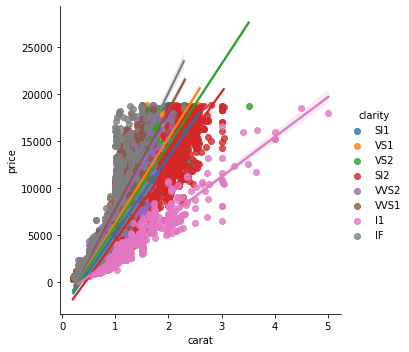

In [470]:
sns.lmplot(data = data, x = 'carat', y = 'price', hue = 'clarity');

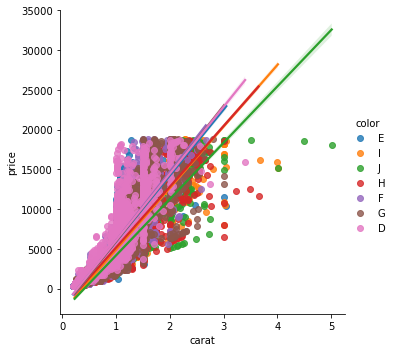

In [471]:
sns.lmplot(data = data, x = 'carat', y = 'price', hue = 'color');

### Clean database

#### Disconsidered | Modifications that increased the root mean squared error

Transforming column 'price' into normal distribution to remove outliers

Result: no outliers found more than 3 standard deviations away from the mean

Test: removing outliers more than 2 standard deviations away from the mean increases the RMSE

In [472]:
transformed_data = boxcox(data['price'])[0]
boxcox_index = boxcox(data['price'])[1]

#sns.histplot(transformed_data);
#fig, ax = plt.subplots()
#stats.probplot(transformed_data, plot=ax);
#sns.boxplot(x = transformed_data);

mean = np.mean(transformed_data)
std = np.std(transformed_data)
lower_cut = mean - 3*std
upper_cut = mean + 3*std

#data['transformed_price'] = transformed_data
#data[(data['transformed_price'] < upper_cut) & (data['transformed_price'] > lower_cut)]

### Compare historical data with Rick's data

In [473]:
data.describe()

,carat,depth,table,price,x,y,z
count,48940.000000,48940.000000,48940.000000,48940.000000,48940.000000,48940.000000,48940.000000
mean,0.797817,61.751931,57.451161,3934.409644,5.730712,5.734333,3.538648
std,0.474126,1.430026,2.233450,3989.333861,1.121920,1.145344,0.706817
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,949.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2401.000000,5.690000,5.710000,3.520000
75%,1.040000,62.500000,59.000000,5331.250000,6.540000,6.540000,4.040000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


In [474]:
rick.describe()

,carat,depth,table,x,y,z
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.799144,61.724680,57.516140,5.735516,5.736410,3.539576
std,0.472936,1.457691,2.244019,1.120300,1.110345,0.694733
min,0.200000,44.000000,50.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,4.720000,4.720000,2.910000
50%,0.710000,61.800000,57.000000,5.710000,5.720000,3.530000
75%,1.040000,62.500000,59.000000,6.530000,6.520000,4.032500
max,4.130000,73.600000,70.000000,10.000000,9.850000,6.430000


In [475]:
data.shape

(48940, 10)

#### Removing historical data that won't be necessary when estimating prices

In [485]:
col_list = ['carat', 'depth', 'table', 'x', 'y', 'z']
for col in col_list:
    data = data[~(data[col] < rick[col].min()) & ~(data[col] > rick[col].max())]

In [486]:
data.shape

(48917, 10)

### Build model

In [492]:
columns = ['carat', 'depth', 'table', 'x']
rel_a = 'color'
rel_b = 'clarity'

def predict_price(columns, rel_a, rel_b):
    rick['price_predicted'] = 0
    for a in data[rel_a].unique():
        for b in data[rel_b].unique():
            model = LinearRegression()
            X = data[(data[rel_a] == a) & (data[rel_b] == b)][columns]
            y = data[(data[rel_a] == a) & (data[rel_b] == b)]['price']
            model.fit(X,y)
            X_rick = rick[(rick[rel_a] == a) & (rick[rel_b] == b)][columns]
            rick.loc[((rick[rel_a] == a) & (rick[rel_b] == b)),'price_predicted'] = model.predict(X_rick)
    rick.to_csv('rick_prices.csv', index = False)
    return 'Price predicted in rick_prices.csv!'

In [493]:
predict_price(columns, rel_a, rel_b)

'Price predicted in rick_prices.csv!'

### Tries

#### 1) Your root mean squared error is 1605.15175707362
Using linear regression of carat related to price.

#### 2) Your root mean squared error is 1605.1525442863103
Using linear regression of carat related to price after removing price values more than 2 standard deviations away from the mean.

#### 3) Your root mean squared error is 1605.3464712564132
Using linear regression of carat related to price after removing historical data (carat, depth and table) that would't affect Rick's prices

#### 4) Your root mean squared error is 1599.1245298339925
Using linear regression of carat and depth related to price after removing historical data (carat, depth and table) that would't affect Rick's prices

#### 5) Your root mean squared error is 1583.834574315603
Using linear regression of carat, depth and table related to price after removing historical data (carat, depth and table) that would't affect Rick's prices

#### 6) Your root mean squared error is 1584.0322082194373
Using linear regression of carat, depth and table related to price after removing historical data (carat, depth, table, x, y and z) that would't affect Rick's prices

#### 7) Your root mean squared error is 1564.5429813765497
Using linear regression of carat, depth, table and x related to price after removing historical data (carat, depth, table, x, y and z) that would't affect Rick's prices

#### 8) Your root mean squared error is 1560.4168934863962
Using linear regression of carat, depth, table, x and y related to price after removing historical data (carat, depth, table, x, y and z) that would't affect Rick's prices

#### 9) Your root mean squared error is 1560.4696333722884
Using linear regression of carat, depth, table, x, y and z related to price after removing historical data (carat, depth, table, x, y and z) that would't affect Rick's prices

#### 10) Your root mean squared error is 1579.007372606321
Using linear regression of carat, table, x and y related to price after removing historical data (carat, depth, table, x, y and z) that would't affect Rick's prices

#### 11) Your root mean squared error is 1456.3841869992268
Using linear regression of carat, depth, table, x and y related to price creating a model for each color after removing historical data (carat, depth, table, x, y and z) that would't affect Rick's prices

#### 12) Your root mean squared error is 1510.3861458586653
Using linear regression of carat and depth related to price creating a model for each color after removing historical data (carat, depth, table, x, y and z) that would't affect Rick's prices

#### 13) Your root mean squared error is 1514.7994760575596
Using linear regression of carat and depth related to price creating a model for each color after removing historical data (carat, depth, table, x, y and z) that would't affect Rick's prices

#### 14) Your root mean squared error is 1129.6421260116958
Using linear regression of carat, depth, table, x and y related to price creating a model for each clarity after removing historical data (carat, depth, table, x, y and z) that would't affect Rick's prices

#### 15) Your root mean squared error is 1560.4168934863962
Using linear regression of carat, depth, table, x and y related to price creating a model for 4 different clarity groups after removing historical data (carat, depth, table, x, y and z) that would't affect Rick's prices

#### 16) Your root mean squared error is 721.3128677580671
Using linear regression of carat, depth, table, x and y related to price creating a model for each clarity and color after removing historical data (carat, depth, table, x, y and z) that would't affect Rick's prices

#### 17) Your root mean squared error is 709.6125147541211
Using linear regression of carat, depth, table and x related to price creating a model for each clarity and color after removing historical data (carat, depth, table, x, y and z) that would't affect Rick's prices

#### 18) Your root mean squared error is 987.8265682322505
Using linear regression of carat, depth and table related to price creating a model for each clarity and color after removing historical data (carat, depth, table, x, y and z) that would't affect Rick's prices

#### 19) Your root mean squared error is 726.4075535809208
Using linear regression of carat, depth and x related to price creating a model for each clarity and color after removing historical data (carat, depth, table, x, y and z) that would't affect Rick's prices

#### 20) Your root mean squared error is 710.0707667113912
Using linear regression of carat, depth, table x and z related to price creating a model for each clarity and color after removing historical data (carat, depth, table, x, y and z) that would't affect Rick's prices

#### 21) Your root mean squared error is 738.7198314265011
Using linear regression of carat, depth, table x and y related to price creating a model for each clarity and color after removing historical data (carat, depth, table, x, y and z) that would't affect Rick's prices